<div class="jumbotron jumbotron-fluid">
  <div class="container">
    <p class="h1" style="color:blue; text-align:center">Implémentez un modèle de<br/>scoring </p>

L’entreprise souhaite mettre en œuvre un outil de `scoring crédit` pour calculer la probabilité qu’un client rembourse son crédit, puis classifie le client en `Défaut(D - classe 1)` ou  `Non-Défaut (ND - Classe 0`). Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

L'objectif est donc d'utiliser ces données financières et socio-économiques historiques pour prédire si un client donné sera en mesure de rembourser le prêt accordé. Il s'agit d'une tâche de classification supervisée standard :

- **Supervisé** : les étiquettes sont incluses dans les données d'entraînement et l'objectif est d'entraîner un modèle pour apprendre à prédire les étiquettes à partir des caractéristiques
- **Classification** : La target est une variable binaire, 0 (credit accordé), 1 (credit refusé)


<h2 style="color:green; text-align:left;"> 0. Problématique Business </h2>

Lorsqu'une instituation financière prête de l'argent à une personne, elle prend le risque que cette dernière `ne rembourse pas cet argent dans le délai convenu`. Ce risque est appelé **Risque de Crédit**. Alors avant d'octroyer du crédit, les instituation financière vérifient si la personne qui demandent un prêt sera capable ou pas de le rembourser (`solvabilité`). 

Grâce à des modèles de Machine Learning, les intitutions financières peuvent modéliser la **probabilité de défaut - `PD`**  de paiement  et ainsi attribuer un `score` à chaque nouveau demandeur de crédit : **Credit Scoring**. 

Dans ce projet, nous apprendrons à construire et évaluer un modèle de Machine Learning pour prédire si un demandeur de crédit sera en défaut de paiement ou non. Il s'agit d'un problème de **classification binaire**. 


En générale le défaut est observé en fonction du taux d'endette, plus celui-ci est élevé, plus le probabilité que le client ne rembpurse pas son credit soit élévé. 

Mais dans le cas espèce, l'évènement défaut est déclenché lorsque le client est difficulté de paiement c-à-d qu'il a un retard de paiementde plus de X jours sur au moins une des Y premières échéances.

<h2 style="color:green; text-align:left;"> 1. Mise en Place de l'Environnement de Travail </h2>

#### Import des librairies utiles à l'analyse exploratoire

In [1]:
# Importation des librairies Python nécessaires
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display


# Utils 
import os
import gc
import time
import missingno as msno
from contextlib import contextmanager

# Librairie de preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Librairie de modélisation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#### Format d'affichage des données

In [2]:
# Affichage d'un maximum de les lignes et colonnes
pd.set_option('display.max_column', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 200)

#pd.options.display.float_format = '{:, .2f}'.format

#chiffre après la virgule
pd.set_option('display.precision', 3)

# Affichage des erreurs
import warnings
warnings.filterwarnings("ignore")

<p class="h2"; style="color:green; text-align:left; background-color:white"> 2. Chargement et Presentation du Jeu de données  </p>

<p class="h3"; style="color:blue">2.1  Descrition des Jeu de données </p>

Il existe 7 fichiers de données différents :

- **application_train/application_test** : les jeu de données de test et d'entrainement avec des informations sur chaque demande de prêt. Chaque prêt a sa propre ligne et est identifié par le `SK_ID_CURR`. Le jeu de données d'entrainement est accompagnées de la TARGET indiquant 0 : le prêt a été remboursé et 1 : le prêt n'a pas été remboursé.

- **bureau** : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans le bureau et est identifié par le `SK_ID_BUREAU`. Chaque prêt dans les données de l'application/demande peut avoir plusieurs crédits précédents.

- **bureau_balance** : les données mensuelles sur les crédits précédents dans le bureau. Chaque ligne correspond à un mois d'un crédit précédent, et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.

- **previous_application** : demandes de prêt précédentes auprès de l'intitution des clients qui ont des prêts dans le dataset **application**. Chaque prêt en cours dans application_data peut avoir plusieurs prêts précédents. Chaque previous_application a une ligne et est identifiée par la caractéristique `SK_ID_PREV`.

- **POS_CASH_BALANCE** : données mensuelles sur les points de vente précédents ou les prêts en espèces que les clients ont eus avec Home Credit. Chaque ligne correspond à un mois d'un point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.

- **credit_card_balance** : données mensuelles sur les cartes de crédit précédentes que les clients ont eues avec l'institution financière. Chaque ligne correspond à un mois du solde d'une carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.

- **installments_payment** : historique de paiement pour les prêts précédents chez l'institution financière. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.




**Source Jeu de données** : https://www.kaggle.com/c/home-credit-default-risk/data

Kernel Kaggle Utilisées : 
- HomeCreditRisk: Extensive EDA + Baseline -> https://www.kaggle.com/code/shivamb/homecreditrisk-extensive-eda-baseline-0-772

> Le diagramme ci-dessous (fourni par l'institutin financière) montre comment les tables sont liées. Cela sera pourrait être utile lorsque nous aurons besoin de définir des relations.

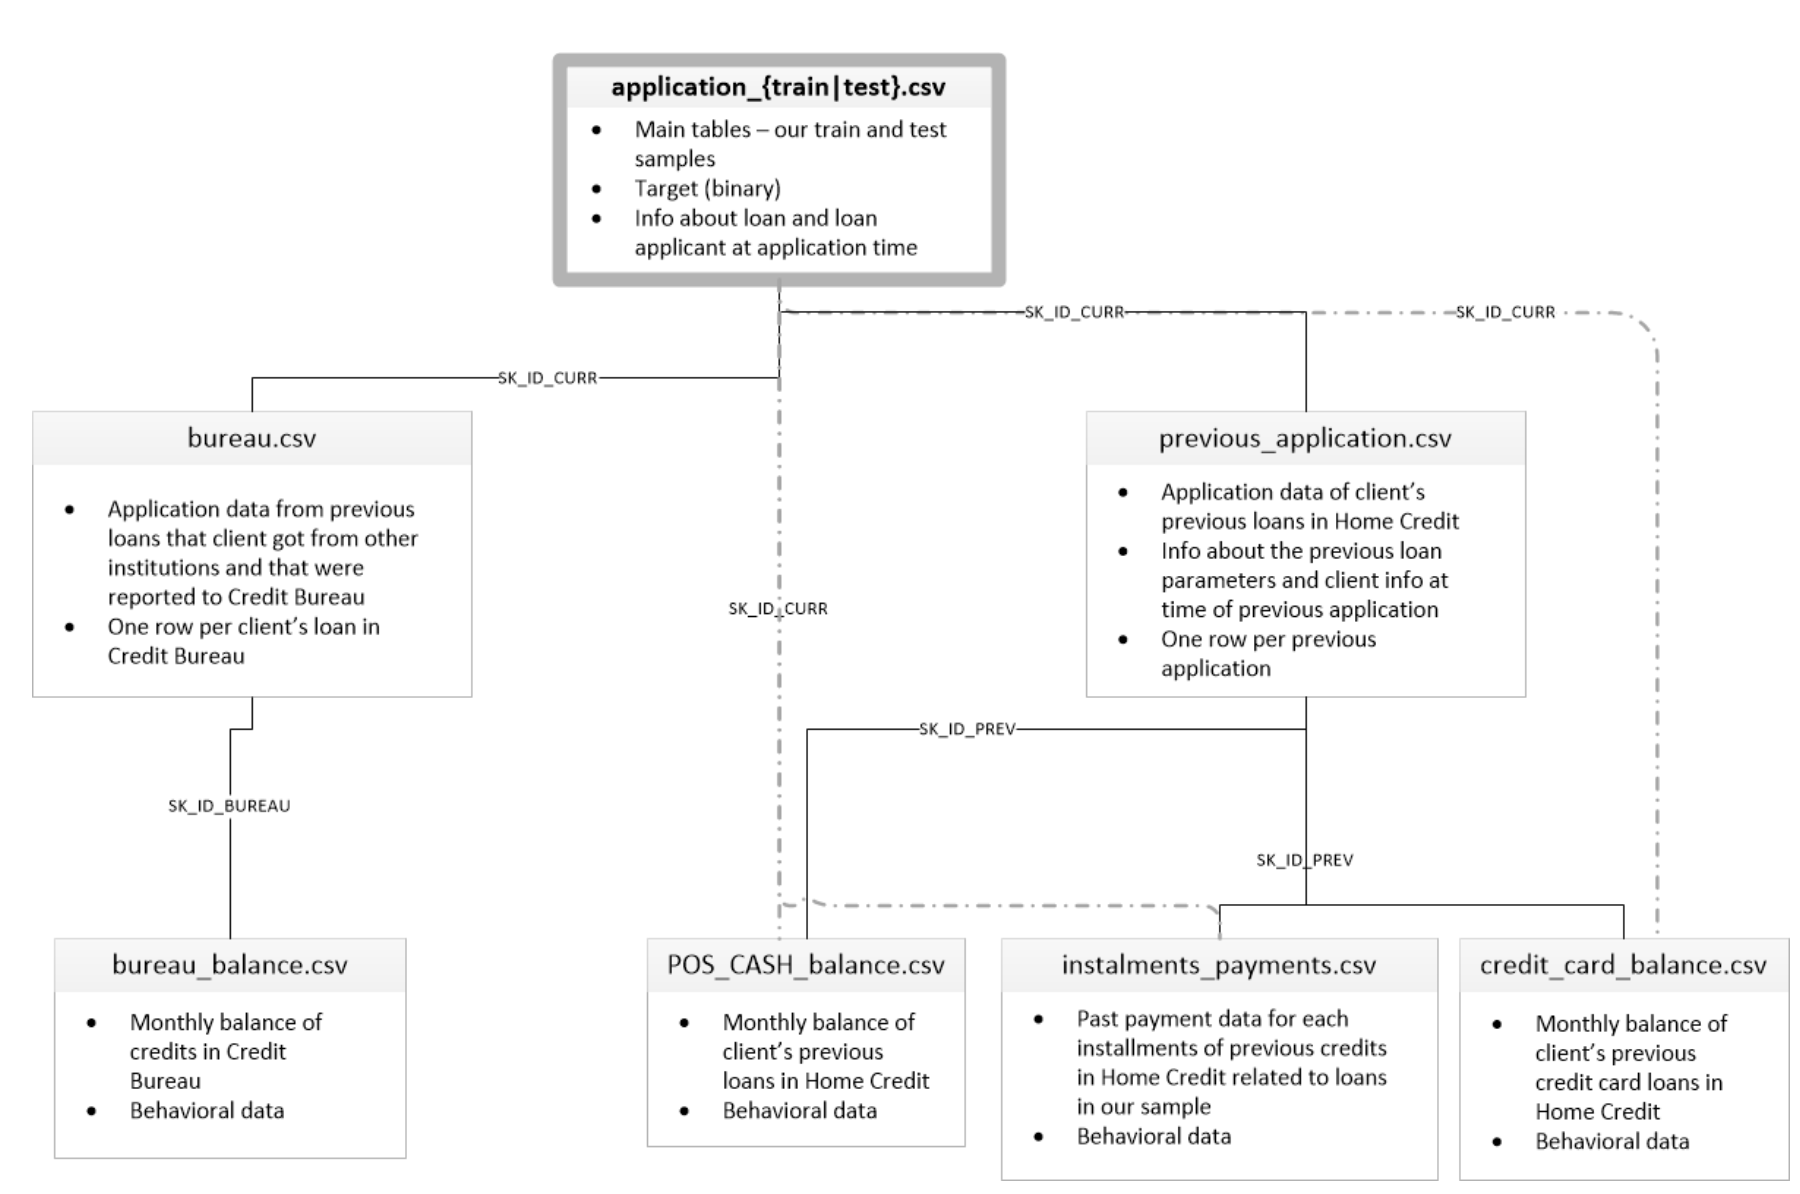

In [3]:
from contextlib import contextmanager
import time

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [4]:
# Compression des données au format .parquet
def write_parquet_file():
    with timer("reading and writing application_train data to parquet"):
        application_train = pd.read_csv('data/application_train.csv')
        application_train.to_parquet('data/application_train.parquet')
        del application_train
        gc.collect()
    
    with timer("reading and writing application_test data to parquet"):
        application_test = pd.read_csv('data/application_test.csv')                    
        application_test.to_parquet('data/application_test.parquet')
        del application_test
        gc.collect()
    
    with timer("reading and writing previous_application data to parquet"):
        previous_application = pd.read_csv('data/previous_application.csv')
        previous_application.to_parquet('data/previous_application.parquet')
        del previous_application
        gc.collect()
    
    with timer("reading and writing bureau data to parquet"):                              
        bureau = pd.read_csv('data/bureau.csv')
        bureau.to_parquet('data/bureau.parquet')
        del bureau
        gc.collect()
        
    
    with timer("reading and writing bureau_balance data to parquet"):
        bureau_balance = pd.read_csv('data/bureau_balance.csv')                    
        bureau_balance.to_parquet('data/bureau_balance.parquet')
        del bureau_balance
        gc.collect()
    
    with timer("reading and writing POS_CASH_balance data to parquet"):
        POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv')
        POS_CASH_balance.to_parquet('data/POS_CASH_balance.parquet')
        del POS_CASH_balance
        gc.collect()
    
    with timer("reading and writing installments_payments data to parquet"):
        installments_payments = pd.read_csv('data/installments_payments.csv')
        installments_payments.to_parquet('data/installments_payments.parquet')
        del installments_payments
        gc.collect()
    
    with timer("reading and writing credit_card_balance data to parquet"):
        credit_card_balance = pd.read_csv('data/credit_card_balance.csv')
        credit_card_balance.to_parquet('data/credit_card_balance.parquet')
        del credit_card_balance
        gc.collect()

<p class="h3"; style="color:blue">2.2 Importation des jeux de donnnées </p>

In [ ]:
# Read and write all datasets into parquet format
write_parquet_file()

In [5]:
# List files available
print(os.listdir("./data/"))

['application_test.csv', 'bureau.parquet', '.DS_Store', 'previous_application.parquet', 'installments_payments.parquet', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.parquet', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', '.ipynb_checkpoints', 'previous_application.csv', 'application_train.parquet', 'bureau_balance.csv', 'bureau_balance.parquet', 'sample_submission.csv', 'credit_card_balance.parquet', 'application_test.parquet']


In [6]:
def read_datasets():   
    with timer("Datasets loaded"):
        print("Loading data ... ")
        app_train = pd.read_parquet('data/application_train.parquet')
        print("\tapplication_train cols_num: {}, obervations: {}".format(len(app_train.columns),
                                                                         app_train.shape[0]))
        app_test = pd.read_parquet('data/application_test.parquet')
        print("\tapplication_test cols_num: {}, obervations: {}".format(len(app_test.columns), 
                                                                        app_test.shape[0]))
        prev_app = pd.read_parquet('data/previous_application.parquet')
        print("\tprevious_application cols_num: {}, obervations: {}".format(len(prev_app.columns), 
                                                                            prev_app.shape[0]))
        bureau = pd.read_parquet('data/bureau.parquet')
        print("\tbureau cols_num: {}, obervations: {}".format(len(bureau.columns), 
                                                              bureau.shape[0]))
        bur_bal = pd.read_parquet('data/bureau_balance.parquet')
        print("\tbureau_balance cols_num: {}, obervations: {}".format(len(bur_bal.columns),
                                                                      bur_bal.shape[0]))
        pos_cash_bal = pd.read_parquet('data/POS_CASH_balance.parquet')
        print("\tPOS_CASH_balance cols_num: {}, obervations: {}".format(len(pos_cash_bal.columns), 
                                                                        pos_cash_bal.shape[0]))
        inst_pay = pd.read_parquet('data/installments_payments.parquet')
        print("\tinstallments_payments cols_num: {}, obervations: {}".format(len(inst_pay.columns), 
                                                                             inst_pay.shape[0]))
        cred_card_bal = pd.read_parquet('data/credit_card_balance.parquet')
        print("\tcredit_card_balance cols_num: {}, obervations: {}".format(len(cred_card_bal.columns), 
                                                                           cred_card_bal.shape[0]))

        return app_train, app_test, prev_app, bureau, bur_bal, pos_cash_bal, inst_pay, cred_card_bal

In [7]:
# Reading all files
app_train, app_test, prev_app, bureau, bur_bal, pos_cash_bal, inst_pay, cred_card_bal= read_datasets()

Loading data ... 
	application_train cols_num: 122, obervations: 307511
	application_test cols_num: 121, obervations: 48744
	previous_application cols_num: 37, obervations: 1670214
	bureau cols_num: 17, obervations: 1716428
	bureau_balance cols_num: 3, obervations: 27299925
	POS_CASH_balance cols_num: 8, obervations: 10001358
	installments_payments cols_num: 8, obervations: 13605401
	credit_card_balance cols_num: 23, obervations: 3840312
Datasets loaded - done in 8s


In [9]:
#app_train.head()

In [356]:
#sample_submission = pd.read_csv("data/sample_submission.csv", delimiter=',',header='infer')
#sample_submission.head()

In [358]:
columns_description = pd.read_csv("data/HomeCredit_columns_description.csv", encoding='cp1252')
columns_description.drop(columns="Unnamed: 0", inplace=True)
#columns_description.head()

<p class="h3"; style="color:blue">2.3 Analyse de forme la forme du Jeu de données </p>

In [15]:
# Collections for each dataset
datasets = [app_train, app_test, prev_app, bureau, bur_bal, pos_cash_bal, inst_pay, cred_card_bal, 
            sample_submission]

names = ['application_train', 'application_test','previous_application', 'bureau', 'bureau_balance',
         'POS_CASH_balance', 'installments_payments', 'credit_card_balance', 'sample_submission']


# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) 
                                 for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) 
                             for df in datasets]

In [16]:
data_info.style.background_gradient()

<p class="h3"; style="color:blue">2.4 Jointure des datasets en un seul jeu de données </p>

In [57]:
# Jointure application train et test 

def app_train_test():
    # Read data and merge
    application_train = pd.read_parquet('data/application_train.parquet')
    application_test = pd.read_parquet('data/application_test.parquet')
    
    application_test['is_test'] = 1 
    application_test['is_train'] = 0
    application_train['is_test'] = 0
    application_train['is_train'] = 1
    
    # target variable
    train_y = application_train['TARGET']
    
    # Train and test datas
    train_X = application_train.drop(['TARGET'], axis = 1)
    test_X = application_test
    
    # merge train and test datasets for preprocessing
    app_train_test = pd.concat([train_X, test_X], axis=0)
    app_train_test.insert(1, 'TARGET', app_train['TARGET']) 
    
    #df_initial = app_train_test.copy()
    
    
    return app_train_test, trainX, trainy, testX

In [58]:
df_initial, trainX_i, trainy_i, testX_i = app_train_test()

df_initial.shape, trainX_i.shape, trainX_i.shape, trainX_i.shape

((356255, 124), (307511, 188), (307511, 188), (307511, 188))

In [62]:
print("Taille jeu de données initial : ", df_initial.shape)
df_initial.head(2)

(356255, 124)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0   4.066e+05      24700.5   
1               N             0          270000.0   1.294e+06      35698.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0        3.510e+05   Unaccompanied          Working   
1        1.130e+06          Family    State servant   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019       -9461           -637            -3648.0   
1                       0.004      -16765          -1188            -1186.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0         0.083         0.263         0.139           0.025             0.037   
1         0.311         0.622           NaN           0.096             0.053   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                        0.972            0.619           0.014   
1                        0.985            0.796           0.060   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00          0.069          0.083          0.125         0.037   
1           0.08          0.035          0.292          0.333         0.013   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                 0.020           0.019                    0.000   
1                 0.077           0.055                    0.004   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0               0.00            0.025              0.038   
1               0.01            0.092              0.054   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0                         0.972             0.634            0.014   
1                         0.985             0.804            0.050   

   ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  \
0           0.000           0.069           0.083           0.125   
1           0.081           0.035           0.292           0.333   

   LANDAREA_MODE  

In [302]:
#print("Taille jeu de données final : ", df_final.shape)
#df_final.head(2)

In [26]:
# Fonction permettant d'avoir une description du dataset

def dataset_overview(df):
    ''' function taking a dataframe in input and prints a dataframe summary containing
    number of rows, columns, missing cells and duplicate rows'''
    
    print('******** Dataset Overview *****\n')
    
    print ('Shape of the Dataset : {}'.format(df.shape))
    print ('Number of variables : {}'.format(df.shape[1]))
    print (' - Num. Quantitative variables : {}'.format(len(df.select_dtypes(include=["float64","int64"]).columns)))
    print (' - Num. Catégorielles variables : {}'.format(len(df.select_dtypes(include=["object"]).columns)))
    print ('Number of obervations : {}'.format(df.shape[0]))
    print ('Number of cells : {}'.format(df.size))
    print ('Missing cells : {}'.format(df.isna().sum().sum()))
    print ('Missing cells in % : {:.2%}'.format(df.isna().sum().sum()/(df.size)))
    print ('Duplicate rows : {}'.format(len(df)-len(df.drop_duplicates())))
    print ('Duplicate rows in % : {:.4%}'.format((len(df)-len(df.drop_duplicates())) / (df.shape[0])))
    print("\n************** End ************")

In [27]:
dataset_overview(df_final)

******** Dataset Overview *****

Shape of the Dataset : (356255, 192)
Number of variables : 192
 - Num. Quantitative variables : 176
 - Num. Catégorielles variables : 16
Number of obervations : 356255
Number of cells : 68400960
Missing cells : 18488785
Missing cells in % : 27.03%
Duplicate rows : 0
Duplicate rows in % : 0.0000%

************** End ************


In [65]:
dataset_overview(df_initial)

******** Dataset Overview *****

Shape of the Dataset : (356255, 124)
Number of variables : 124
 - Num. Quantitative variables : 108
 - Num. Catégorielles variables : 16
Number of obervations : 356255
Number of cells : 44175620
Missing cells : 10556884
Missing cells in % : 23.90%
Duplicate rows : 0
Duplicate rows in % : 0.0000%

************** End ************


In [47]:
def cat_num_variable(df):
    
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    ignore_features = ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']
    all_numeric_columns = df.select_dtypes(exclude=['object']).columns.to_list()
    numeric_columns = [col for col in all_numeric_columns if col not in ignore_features]
    
    print("Number of categorical features: ", len(categorical_columns))
    print("First 05 cat. features :", cat_columns[:5])
    print("\nNumber of categorical features: ",len(numeric_columns))
    print("First 05 num. Features :",num_columns[:5], "\n")
    
    return categorical_columns, numeric_columns

In [66]:
cat_columns, num_columns = cat_num_variable(df_initial)

Number of categorical features:  16
First 05 cat. features : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE']

Number of categorical features:  104
First 05 num. Features : ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'] 



<p class="h2"; style="color:green; text-align:left; background-color:white"> 3. Analyse des valeurs manquantes et Mise en forme des données</p>


L'un des problèmes les plus courants auxquels les data scientists doivent faire face est celui des **données incomplètes ou manquantes**. 

- Alors, comment saurions-nous que le DataFrame contient des valeurs manquantes ? 
- Comment ses données sont traitées

Telles sont les sujets que nous aborderons dans cette partie


<p class="h3"; style="color:blue">3.1 Analyse et traitement des valeurs manquantes </p>

In [49]:
# Fonction qui renvoie la proportion de NaN sur l'ensemble du dataset
def print_proportion_nan(df):
    print('Taille du jeu de données : ', df.shape)
    print(' --> Proportion de NaN : {:.2%}'.format(df.isna().sum().sum()/(df.shape[0]*df.shape[1]))) 
              
    return None

In [67]:
print_proportion_nan(df_initial)

Taille du jeu de données :  (356255, 124)
 --> Proportion de NaN : 23.90%


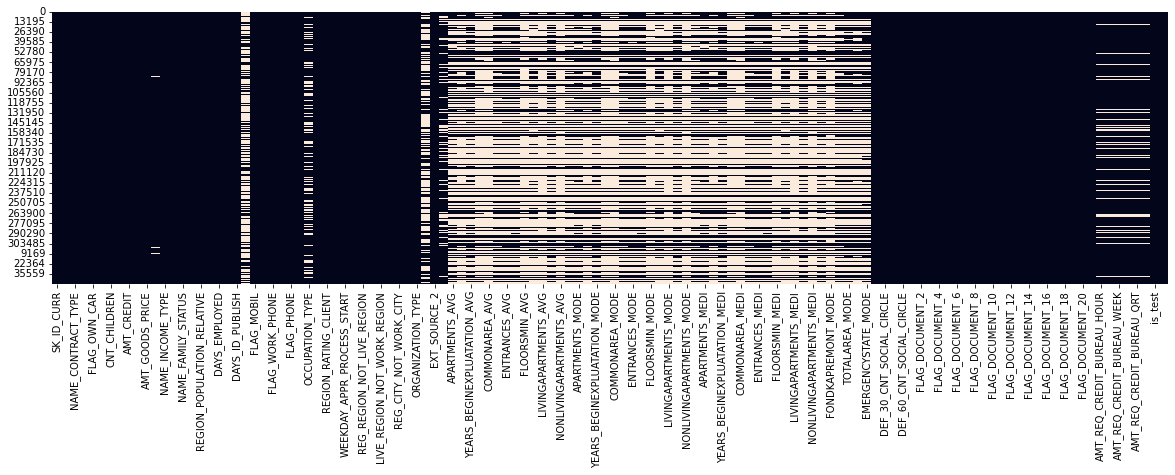

In [68]:
plt.figure(figsize=(20,5))
sns.heatmap(df_initial.isna(), cbar=False)
plt.show()

In [77]:
# **Répartition des données entre les variables des colonnes**
def graphe_remplissage_variable(df):
  # Répartition du taux de remplissage des colonnes: 
    df = pd.DataFrame(round(df.shape[0] - df.isna().sum())/df.shape[0],
                    columns=['Taux de remplissage']).sort_values('Taux de remplissage', 
                                                                 ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(20,30))
    sns.barplot(y=df['index'], x='Taux de remplissage', data=df)
    plt.title('Taux de remplissage des variables en %\n', fontsize = 15)
    plt.show()

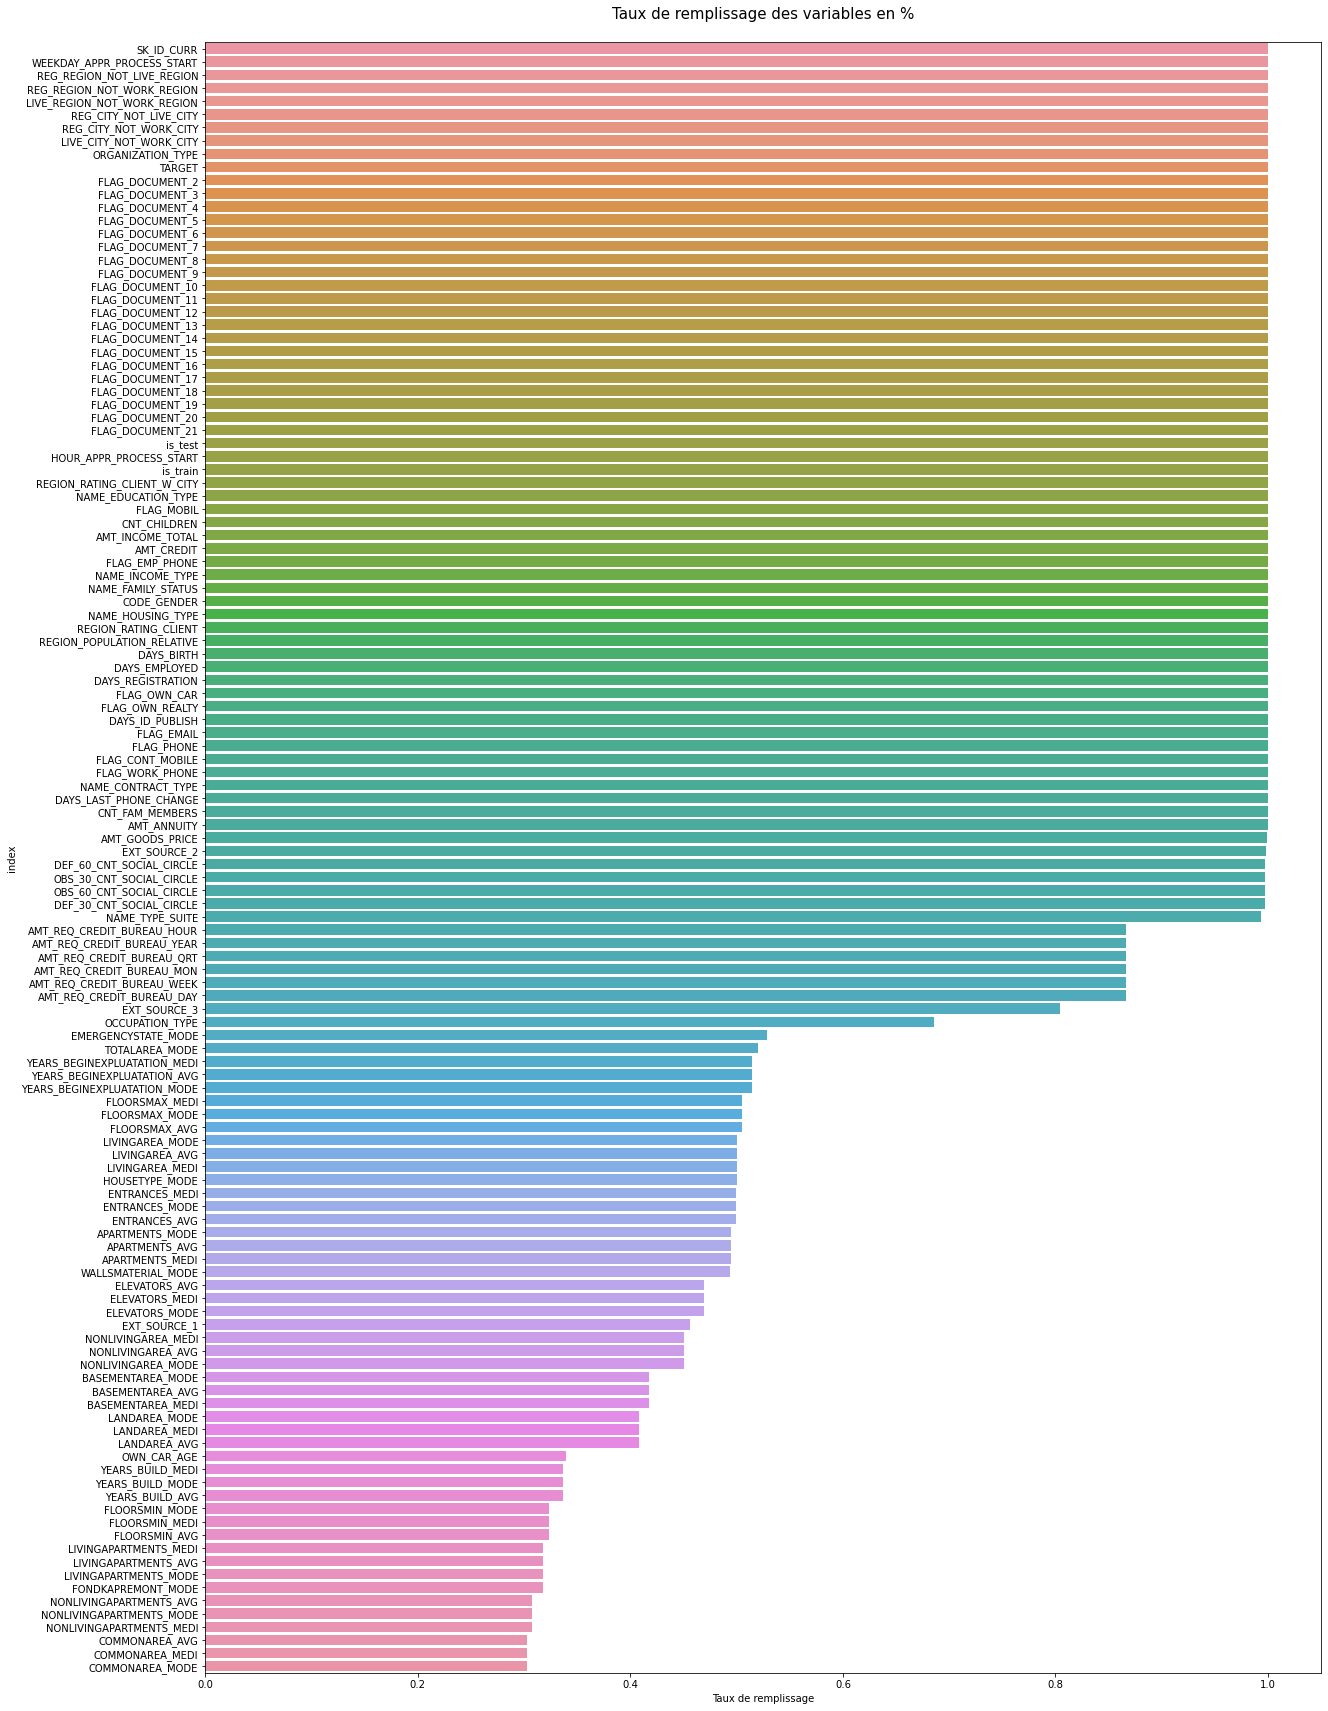

In [78]:
graphe_remplissage_variable(df_initial)

In [75]:
def cols_null_percent(df): 
    return (100 * df.isnull().sum() / len(df)).sort_values(ascending=False).round(3)

In [76]:
cols_null_percent(df_initial)

COMMONAREA_MODE                 69.714
COMMONAREA_AVG                  69.714
COMMONAREA_MEDI                 69.714
NONLIVINGAPARTMENTS_MEDI        69.293
NONLIVINGAPARTMENTS_AVG         69.293
NONLIVINGAPARTMENTS_MODE        69.293
FONDKAPREMONT_MODE              68.235
LIVINGAPARTMENTS_MEDI           68.204
LIVINGAPARTMENTS_AVG            68.204
LIVINGAPARTMENTS_MODE           68.204
FLOORSMIN_MEDI                  67.678
FLOORSMIN_AVG                   67.678
FLOORSMIN_MODE                  67.678
YEARS_BUILD_AVG                 66.331
YEARS_BUILD_MODE                66.331
YEARS_BUILD_MEDI                66.331
OWN_CAR_AGE                     66.032
LANDAREA_AVG                    59.183
LANDAREA_MODE                   59.183
LANDAREA_MEDI                   59.183
BASEMENTAREA_MODE               58.268
BASEMENTAREA_MEDI               58.268
BASEMENTAREA_AVG                58.268
NONLIVINGAREA_AVG               54.951
NONLIVINGAREA_MODE              54.951
NONLIVINGAREA_MEDI       

In [93]:
def nan_imputation(df):
    
    with timer("Filtering cols with a given % of missing_rate "):
        # deleting all features with more than 
        missing_rate = df.isna().sum()/df.shape[0] 
        df1 = df[df.columns[missing_rate < 0.60]]
    
        # Droping all row containing Nan for feature with less than 1% of Nan
        less_one_percent = df.columns[missing_rate < 0.010].to_list()
        df2 = df1.dropna(subset=less_one_percent)
   
    with timer("Imputing numeric nan value with median "):
        # Filling missing numeric value with median 
        df3 = df2.fillna(df2.median())
    
    with timer("Imputing categorical nan value with Unknown "):
        # Filling missing catégorical value with Unknown
        categorical_columns = [col for col in df3.columns if df3[col].dtype == 'object']
        for col in categorical_columns:
            df3[col] = df3[col].replace(np.nan, 'Unknown')
    
    df_imputed = df3.copy()
    
    num_features_deleted = df.shape[1] - df_imputed.shape[1]
    num_observations_deleted = df.shape[0] - df_imputed.shape[0]
    
    print("\nTaille du jeu de donnée avant imputation: ", df.shape)
    print("Taille du jeu de donnée après imputation: ", df_imputed.shape)
    print(f"\tSoit {num_features_deleted} variables et {num_observations_deleted} observations supprimées")
    print('Proportion de données supprimés : {:.4%}'.format(num_observations_deleted/(df.shape[0]*df.shape[1])))
    
    return df_imputed

In [94]:
df_initial_imputed = nan_imputation(df_initial)

Filtering cols with a given % of missing_rate  - done in 2s
Imputing numeric nan value with median  - done in 3s
Imputing categorical nan value with Unknown  - done in 0s

Taille du jeu de donnée avant imputation:  (356255, 124)
Taille du jeu de donnée après imputation:  (352303, 107)
	Soit 17 variables et 3952 observations supprimées
Proportion de données supprimés : 0.0089%


In [88]:
print_proportion_nan(df_initial_imputed)

Taille du jeu de données :  (352303, 107)
 --> Proportion de NaN : 0.00%


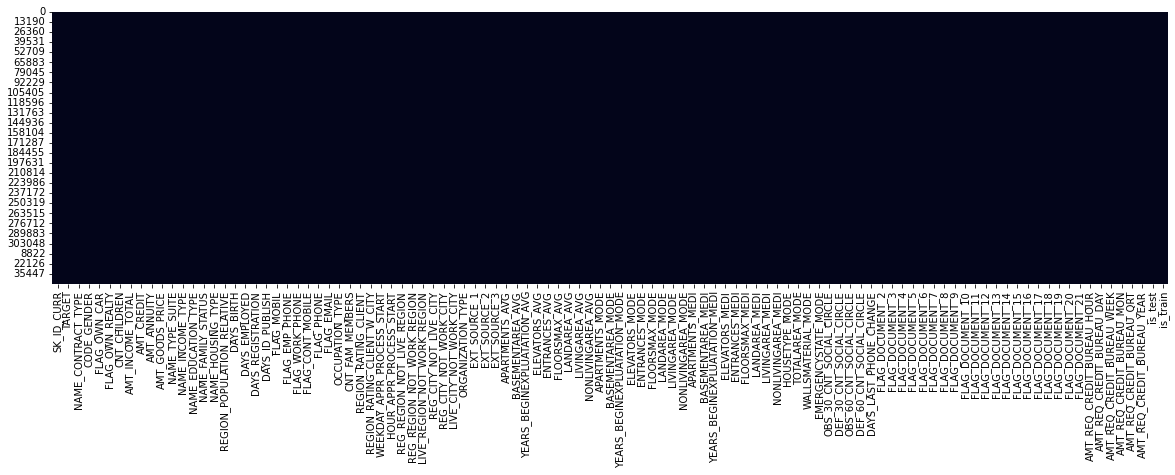

In [89]:
plt.figure(figsize=(20,5))
sns.heatmap(df_initial_imputed.isna(), cbar=False)
plt.show()

<p class="h3"; style="color:blue">3.2 Analyse et traitement des outliers </p>

La présence de valeurs abérrantes peuvent affecter la qualité d'un modèle de Machine Learning. Nous allons donc les traiter. Avant de traiter les valeurs aberrantes, il faut les détecter.

Il existe plusieur méthodes de détection des outliers. Selon la méthode de la gamme (IQR), une valeur est abbérante si : 

- `valeur < Q1 - 1.5 * IQR`
ou 
- `valeur > Q3 - 1.5 * IQR`

avec

> **`IQR = Q3 - Q1`**

In [328]:
df_with_outliers = df_initial_imputed.copy()

In [99]:
df_with_outliers.dtypes.value_counts()

float64    49
int64      43
object     15
dtype: int64

In [100]:
df_with_outliers.describe()

SK_ID_CURR      TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
count  352303.000  352303.000    352303.000         3.523e+05   3.523e+05   
mean   278117.289       0.081         0.414         1.700e+05   5.883e+05   
std    102835.661       0.273         0.720         2.243e+05   3.984e+05   
min    100001.000       0.000         0.000         2.565e+04   4.500e+04   
25%    189057.500       0.000         0.000         1.125e+05   2.700e+05   
50%    278126.000       0.000         0.000         1.530e+05   5.005e+05   
75%    367186.500       0.000         1.000         2.025e+05   7.978e+05   
max    456255.000       1.000        20.000         1.170e+08   4.050e+06   

       AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
count   352303.000        3.523e+05                   3.523e+05  352303.000   
mean     27456.699        5.282e+05                   2.089e-02  -16043.078   
std      14717.246        3.657e+05                   1.389e-02    4356.591   
min       1615.500        4.050e+04                   2.530e-04  -25229.000   
25%      16803.000        2.340e+05                   1.001e-02  -19674.000   
50%      25132.500        4.500e+05                   1.885e-02  -15758.000   
75%      35005.500        6.750e+05                   2.866e-02  -12430.000   
max     258025.500        4.050e+06                   7.251e-02   -7338.000   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
count     352303.000         352303.000       352303.000    352303.0   
mean       64282.843          -4984.269        -3002.261         1.0   
std       141678.619           3525.875         1517.746         0.0   
min       -17912.000         -24672.000        -7197.000         1.0   
25%        -2783.000          -7476.500        -4318.000         1.0   
50%        -1225.000          -4504.000        -3251.000         1.0   
75%         -291.000          -1997.000        -1718.000         1.0   
max       365243.000              0.000            0.000         1.0   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
count      352303.000       352303.000        352303.000  352303.000   
mean            0.819            0.201             0.998       0.279   
std             0.385            0.400             0.042       0.448   
min             0.000            0.000             0.000       0.000   
25%             1.000            0.000             1.000       0.000   
50%             1.000            0.000             1.000       0.000   
75%             1.000            0.000             1.000       1.000   
max             1.000            1.000             1.000       1.000   

       FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  352303.000       352303.000            352303.000   
mean        0.071            2.152                 2.051   
std         0.257            0.908                 0.511   
min         0.000            1.000                 1.000   
25%         0.000            2.000                 2.000   
50%         0.000            2.000                 2.000   
75%         0.000            3.000                 2.000   
max         1.000           21.000                 3.000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                   352303.000               352303.000   
mean                         2.030                   12.053   
std                          0.505                    3.268   
min                         -1.000                    0.000   
25%                          2.000                   10.000   
50%                          2.000                   12.000   
75%                          2.000                   14.000   
max                          3.000                   23.000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                  352303.000                  352303.000   
mean                        0.016                       0.051   

In [ ]:
#numeric_columns = [col for col in all_numeric_columns if col not in ignore_features]
#if df_with_outliers[col].max() > 1.0:
#df_with_outliers["REGION_RATING_CLIENT"].value_counts()
#df_with_outliers["ELEVATORS_MEDI"].max()

In [153]:
col_toAnalyse = []

for col in df_with_outliers.select_dtypes(exclude=['object']).columns:
    if len(df_with_outliers[col].value_counts()) > 2:
        if df_with_outliers[col].max() > 1.0:
            col_toAnalyse.append(col)
print(len(col_toAnalyse))

21


In [134]:
df_with_outliers[col_toAnalyse].dtypes.value_counts()

float64    15
int64       6
dtype: int64

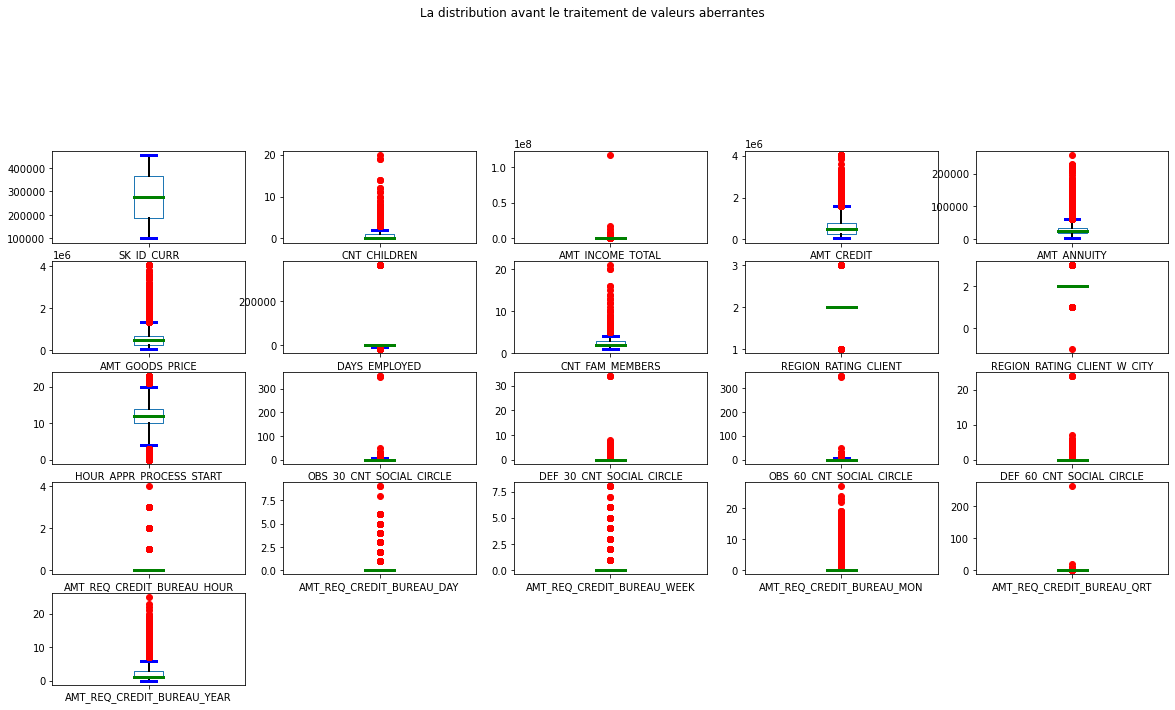

In [154]:
#df.select_dtypes(include=[float]).plot(kind="box",subplots=True,sym="ro")
df_with_outliers[col_toAnalyse].plot(kind="box",subplots=True,sym="ro",
                                            whiskerprops = {'color':'k','linewidth':2,'linestyle':'solid'},
                                            capprops={'color': 'blue', 'linewidth': 3, 'linestyle': 'solid'},
                                            medianprops = {'color':'green','linewidth': 3, 'linestyle': 'solid'},
                                            title="La distribution avant le traitement de valeurs aberrantes",
                                            figsize=(20,20),layout=(10,5)); 

In [152]:
#df_with_outliers["REGION_RATING_CLIENT_W_CITY"].value_counts()

In [141]:
df_with_outliers.describe(include ="object")

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count              352303      352303       352303          352303   
unique                  2           3            2               2   
top            Cash loans           F            N               Y   
freq               323975      232503       232585          244495   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count           352303           352303                         352303   
unique               7                8                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq            286785           181442                         249913   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count              352303             352303          352303   
unique                  5                  6              19   
top               Married  House / apartment         Unknown   
freq               226296             312996          110684   

       WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE HOUSETYPE_MODE  \
count                      352303                  352303         352303   
unique                          7                      58              4   
top                       TUESDAY  Business Entity Type 3        Unknown   
freq                        63136                   77890         176107   

       WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
count              352303              352303  
unique                  8                   3  
top               Unknown                  No  
freq               178422              183388

In [143]:
df_with_outliers["CODE_GENDER"].value_counts()

F      232503
M      119796
XNA         4
Name: CODE_GENDER, dtype: int64

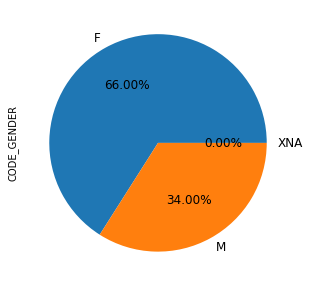

In [147]:
df_with_outliers["CODE_GENDER"].value_counts().plot.pie(figsize=(10, 5), 
                                                    autopct='%.2f%%',
                                                    textprops={'fontsize': 12})
plt.show()

In [157]:
print(col_toAnalyse)

['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [177]:
def removing_outliers(df):
    
    df = df[df['CODE_GENDER'] != 'XNA']
    
    cols_with_outlier = ["CNT_FAM_MEMBERS","AMT_INCOME_TOTAL","AMT_ANNUITY", "DAYS_EMPLOYED",
                         "OBS_60_CNT_SOCIAL_CIRCLE", "OBS_30_CNT_SOCIAL_CIRCLE", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
                         "REGION_POPULATION_RELATIVE", "AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_QRT"] 
    
    for col in cols_with_outlier:
        df = df[df[col] != df[col].max()]
    
    return df 

In [329]:
df_without_outliers = removing_outliers(df_with_outliers)

In [330]:
df_with_outliers.shape, df_without_outliers.shape

((352303, 107), (280575, 107))

In [180]:
num_observations_deleted = df_initial.shape[0] - df_without_outliers.shape[0]

#print('Proportion de données supprimés : {:.4%}'.format(num_observations_deleted/(df.shape[0]*df.shape[1])))
print(f"\tSoit {num_observations_deleted} observations supprimées")

	Soit 75680 observations supprimées


In [182]:
df_without_outliers.describe()

SK_ID_CURR      TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
count  280575.000  280575.000    280575.000         2.806e+05   2.806e+05   
mean   278048.050       0.087         0.498         1.735e+05   5.946e+05   
std    102896.194       0.282         0.762         1.088e+05   3.974e+05   
min    100001.000       0.000         0.000         2.565e+04   4.500e+04   
25%    188859.000       0.000         0.000         1.125e+05   2.725e+05   
50%    278027.000       0.000         0.000         1.575e+05   5.085e+05   
75%    367240.500       0.000         1.000         2.025e+05   8.086e+05   
max    456255.000       1.000        19.000         1.800e+07   4.050e+06   

       AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
count   280575.000        2.806e+05                   2.806e+05  280575.000   
mean     27908.829        5.338e+05                   1.948e-02  -14754.988   
std      14611.134        3.652e+05                   1.110e-02    3646.749   
min       1980.000        4.050e+04                   2.530e-04  -25200.000   
25%      17181.000        2.385e+05                   9.657e-03  -17533.000   
50%      25834.500        4.500e+05                   1.880e-02  -14564.000   
75%      35653.500        6.795e+05                   2.639e-02  -11776.000   
max     230161.500        4.050e+06                   4.622e-02   -7338.000   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
count     280575.000         280575.000       280575.000    280575.0   
mean       -2401.239          -4604.298        -2807.999         1.0   
std         2339.411           3243.912         1521.817         0.0   
min       -17912.000         -22928.000        -7197.000         1.0   
25%        -3202.000          -6906.000        -4195.000         1.0   
50%        -1665.000          -4232.000        -2886.000         1.0   
75%         -782.000          -1811.000        -1486.000         1.0   
max            0.000              0.000            0.000         1.0   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
count      280575.000       280575.000        280575.000  280575.000   
mean            1.000            0.246             0.998       0.267   
std             0.007            0.431             0.044       0.443   
min             0.000            0.000             0.000       0.000   
25%             1.000            0.000             1.000       0.000   
50%             1.000            0.000             1.000       0.000   
75%             1.000            0.000             1.000       1.000   
max             1.000            1.000             1.000       1.000   

       FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  280575.000       280575.000            280575.000   
mean        0.077            2.256                 2.073   
std         0.266            0.940                 0.490   
min         0.000            1.000                 1.000   
25%         0.000            2.000                 2.000   
50%         0.000            2.000                 2.000   
75%         0.000            3.000                 2.000   
max         1.000           20.000                 3.000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                   280575.000               280575.000   
mean                         2.050                   12.136   
std                          0.485                    3.292   
min                         -1.000                    0.000   
25%                          2.000                   10.000   
50%                          2.000                   12.000   
75%                          2.000                   15.000   
max                          3.000                   23.000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                  280575.000                  280575.000   
mean                        0.017                       0.062   

In [306]:
df_initial_cleaned = df_without_outliers.copy()

<p class="h2"; style="color:green; text-align:left; background-color:white"> 4. Analyse Exploratoire des données</p>


The goal here is to find out more about the data and become a subject matter export on the dataset you're working with.

- What question(s) are you trying to solve?
- What kind of data do we have and how do we treat different types?
- What's missing from the data and how do you deal with it?
- Where are the outliers and why should you care about them?
- How can you add, change or remove features to get more out of your data?

In [184]:
df_initial.sample(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
232400      369177       1         Cash loans           M            N   
117679      236455       0         Cash loans           F            N   
303435      451557       1         Cash loans           M            N   
137977      260014       0         Cash loans           F            N   
215944      350215       0         Cash loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
232400               N             1          157500.0   6.750e+05   
117679               Y             0          202500.0   9.000e+05   
303435               Y             0          225000.0   4.222e+05   
137977               Y             3           49500.0   5.450e+05   
215944               N             2          315000.0   1.762e+06   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
232400      19476.0        6.750e+05   Unaccompanied               Working   
117679      38263.5        9.000e+05   Unaccompanied  Commercial associate   
303435      25645.5        3.645e+05   Unaccompanied               Working   
137977      26640.0        4.500e+05   Unaccompanied         State servant   
215944      51651.0        1.575e+06   Unaccompanied               Working   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
232400               Higher education             Separated   
117679  Secondary / secondary special             Separated   
303435              Incomplete higher  Single / not married   
137977  Secondary / secondary special               Married   
215944               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
232400       With parents                       0.015      -10549   
117679  House / apartment                       0.031      -16806   
303435       With parents                       0.019      -10969   
137977  House / apartment                       0.007      -10956   
215944  House / apartment                       0.005      -13737   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
232400           -866            -1765.0            -3192          NaN   
117679          -2670            -8185.0             -350          NaN   
303435          -3233            -5009.0            -3663          NaN   
137977          -3995             -416.0            -3610          NaN   
215944           -786            -1995.0            -4330          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
232400           1               1                0                 1   
117679           1               1                0                 1   
303435           1               1                0                 1   
137977           1               1                0                 1   
215944           1               1                0                 1   

        FLAG_PHONE  FLAG_EMAIL        OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
232400           0           0  High skill tech staff              2.0   
117679           0           0            Sales staff              1.0   
303435           0           0                Drivers              1.0   
137977           0           0                   None              5.0   
215944           0           0  High skill tech staff              4.0   

        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
232400                     2                            2   
117679                     2                            2   
303435                     2                            2   
137977                     2                            2   
215944                     3                            3   

       WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
232400                     MONDAY                        9   
117679                   THURSDAY                        9 

In [186]:
df_initial.dtypes.value_counts()

float64    65
int64      43
object     16
dtype: int64

In [286]:
cat_columns, num_columns = cat_num_variable(df_initial)

Number of categorical features:  16
First 05 cat. features : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE']

Number of categorical features:  104
First 05 num. Features : ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'] 



<p class="h3"; style="color:blue">4.0 Target Variable Analysis </p>

In [236]:
# Let's find out how manay of each class there are

df_initial["TARGET"].value_counts()

0    327503
1     28752
Name: TARGET, dtype: int64

In [238]:
df_initial["TARGET"].value_counts(normalize=True).round(4)*100

0    91.93
1     8.07
Name: TARGET, dtype: float64

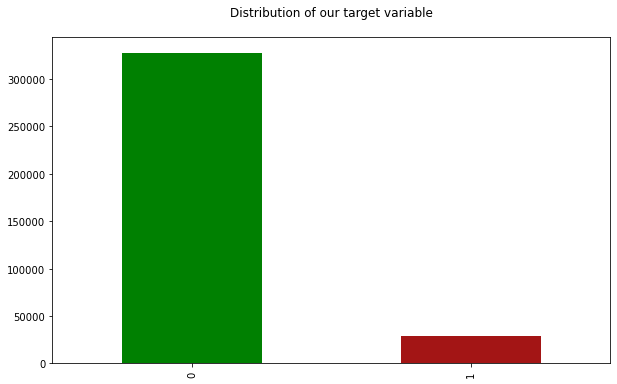

In [241]:
plt.figure(figsize=(10, 6))
df_initial["TARGET"].value_counts().plot(kind="bar", color=["#008001", "#A31515"])
plt.title("Distribution of our target variable\n");

<p class="h3"; style="color:blue">4.1 Univariate Analysis </p>

#### Categorical univariate analysis

In [189]:
df_initial[cat_columns].describe()

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count              356255      356255       356255          356255   
unique                  2           3            2               2   
top            Cash loans           F            N               Y   
freq               326537      235126       235235          246970   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count           354052           356255                         356255   
unique               7                8                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq            288253           183307                         252379   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count              356255             356255          244259   
unique                  6                  6              18   
top               Married  House / apartment        Laborers   
freq               228715             316513           63841   

       WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE FONDKAPREMONT_MODE  \
count                      356255                  356255             113163   
unique                          7                      58                  4   
top                       TUESDAY  Business Entity Type 3   reg oper account   
freq                        63652                   78832              85954   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
count           178339             176021              188291  
unique               3                  7                   2  
top     block of flats              Panel                  No  
freq            175162              77309              185607

In [226]:
from ipywidgets import interact, interactive, fixed, interact_manual

def bar_plot(a):
    df_initial[a].value_counts(normalize = True).plot(kind = 'bar')
    plt.ylabel('proportion')
    plt.title('Distribution of' + str(a))
    return plt.show()

In [227]:
print(cat_columns[:10])

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


In [228]:
interact(bar_plot, a = cat_columns)

interactive(children=(Dropdown(description='a', options=('NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', …

<function __main__.bar_plot(a)>

#### Numerical Univariate Analysis

In [191]:
df_initial[num_columns].describe()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
count    356255.000         3.563e+05   3.563e+05   356219.000   
mean          0.414         1.701e+05   5.878e+05    27425.561   
std           0.720         2.235e+05   3.986e+05    14732.808   
min           0.000         2.565e+04   4.500e+04     1615.500   
25%           0.000         1.125e+05   2.700e+05    16731.000   
50%           0.000         1.530e+05   5.002e+05    25078.500   
75%           1.000         2.025e+05   7.976e+05    34960.500   
max          20.000         1.170e+08   4.050e+06   258025.500   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
count        3.560e+05                   3.563e+05  356255.000     356255.000   
mean         5.280e+05                   2.092e-02  -16041.249      64317.231   
std          3.661e+05                   1.391e-02    4358.804     141705.533   
min          4.050e+04                   2.530e-04  -25229.000     -17912.000   
25%          2.340e+05                   1.001e-02  -19676.000      -2781.000   
50%          4.500e+05                   1.885e-02  -15755.000      -1224.000   
75%          6.750e+05                   2.866e-02  -12425.000       -290.000   
max          4.050e+06                   7.251e-02   -7338.000     365243.000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
count         356255.000       356255.000   121014.000  356255.000   
mean           -4983.594        -3002.071       12.024       1.000   
std             3526.969         1517.902       11.881       0.002   
min           -24672.000        -7197.000        0.000       0.000   
25%            -7477.000        -4318.000        5.000       1.000   
50%            -4502.000        -3252.000        9.000       1.000   
75%            -1995.000        -1717.000       15.000       1.000   
max                0.000            0.000       91.000       1.000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
count      356255.000         356255.0        356255.000  356255.000   
mean            0.818              0.2             0.998       0.279   
std             0.385              0.4             0.043       0.448   
min             0.000              0.0             0.000       0.000   
25%             1.000              0.0             1.000       0.000   
50%             1.000              0.0             1.000       0.000   
75%             1.000              0.0             1.000       1.000   
max             1.000              1.0             1.000       1.000   

       FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  356255.000       356253.000            356255.000   
mean        0.071            2.152                 2.051   
std         0.257            0.908                 0.511   
min         0.000            1.000                 1.000   
25%         0.000            2.000                 2.000   
50%         0.000            2.000                 2.000   
75%         0.000            3.000                 2.000   
max         1.000           21.000                 3.000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                   356255.000               356255.000   
mean                         2.029                   12.056   
std                          0.505                    3.268   
min                         -1.000                    0.000   
25%                          2.000                   10.000   
50%                          2.000                   12.000   
75%                          2.000                   14.000   
max                          3.000                   23.000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                  356255.000                  356255.000   
mean                        0.016                       0.051   
std                         0.124                       0.221   
min                         0.000

In [234]:
# Création d'une fonction de construction de graphiques et de manière interactive

def univariate_num_analysis(df, col):
    
    # Create a figure for 3 subplots (3 rows, 1 column)
    plt.figure(figsize = (15,5))

    # Create a Histogramme on the first axis
    plt.subplot(1, 3, 1)
    plt.hist(x=df[col], color='green')
    plt.title(col + ' \nData Distribution')
    plt.grid(False)

    # Create a Boxplot of our var on the second axis
    plt.subplot(1, 3, 2)
    df.boxplot(col)
    plt.title(col + " \nBox Plot")

    # Plot density
    plt.subplot(1, 3, 3)
    df[col].plot.density()
    plt.title(col + ' \nProb Density')

In [195]:
print(num_columns[:10])

['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']


In [203]:
#interact(univariate_num_analysis(df_initial, col=num_columns))

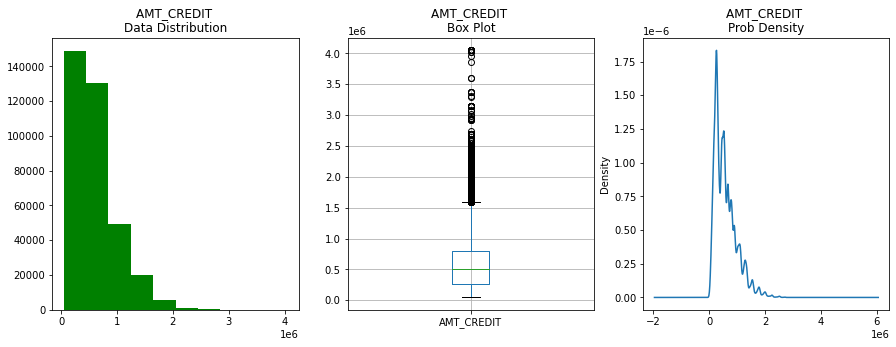

In [225]:
col='AMT_CREDIT'

univariate_num_analysis(df_initial, col)

In [248]:
col_toPlotHist = []

for col in df_initial.select_dtypes(exclude=['object']).columns:
    if len(df_initial[col].value_counts()) > 2:
        col_toPlotHist.append(col)
print(len(col_toPlotHist))

73


In [263]:
df_initial[col_toPlotHist].dtypes.value_counts()
#df_initial.dtypes.value_counts()

float64    65
int64       8
dtype: int64

In [255]:
#df_initial.select_dtypes(include=[int]).columns

In [276]:
df = df_initial.copy()

def histogram_plot(a):
    df[a].plot(kind = 'hist')
    plt.ylabel('proportion')
    plt.title('Historgam of' + str(a))
    return plt.show()

# Création d'une fonction de construction d'histogrammes et de manière interactive
def hist_plot(b):
    sns.distplot(df[b], kde=False)
    plt.title('Histogram of '+str(b))
    return plt.show()

In [277]:
interact(hist_plot, b = num_columns)

interactive(children=(Dropdown(description='b', options=('CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AM…

<function __main__.hist_plot(b)>

In [275]:
#print(col_toPlotHist)

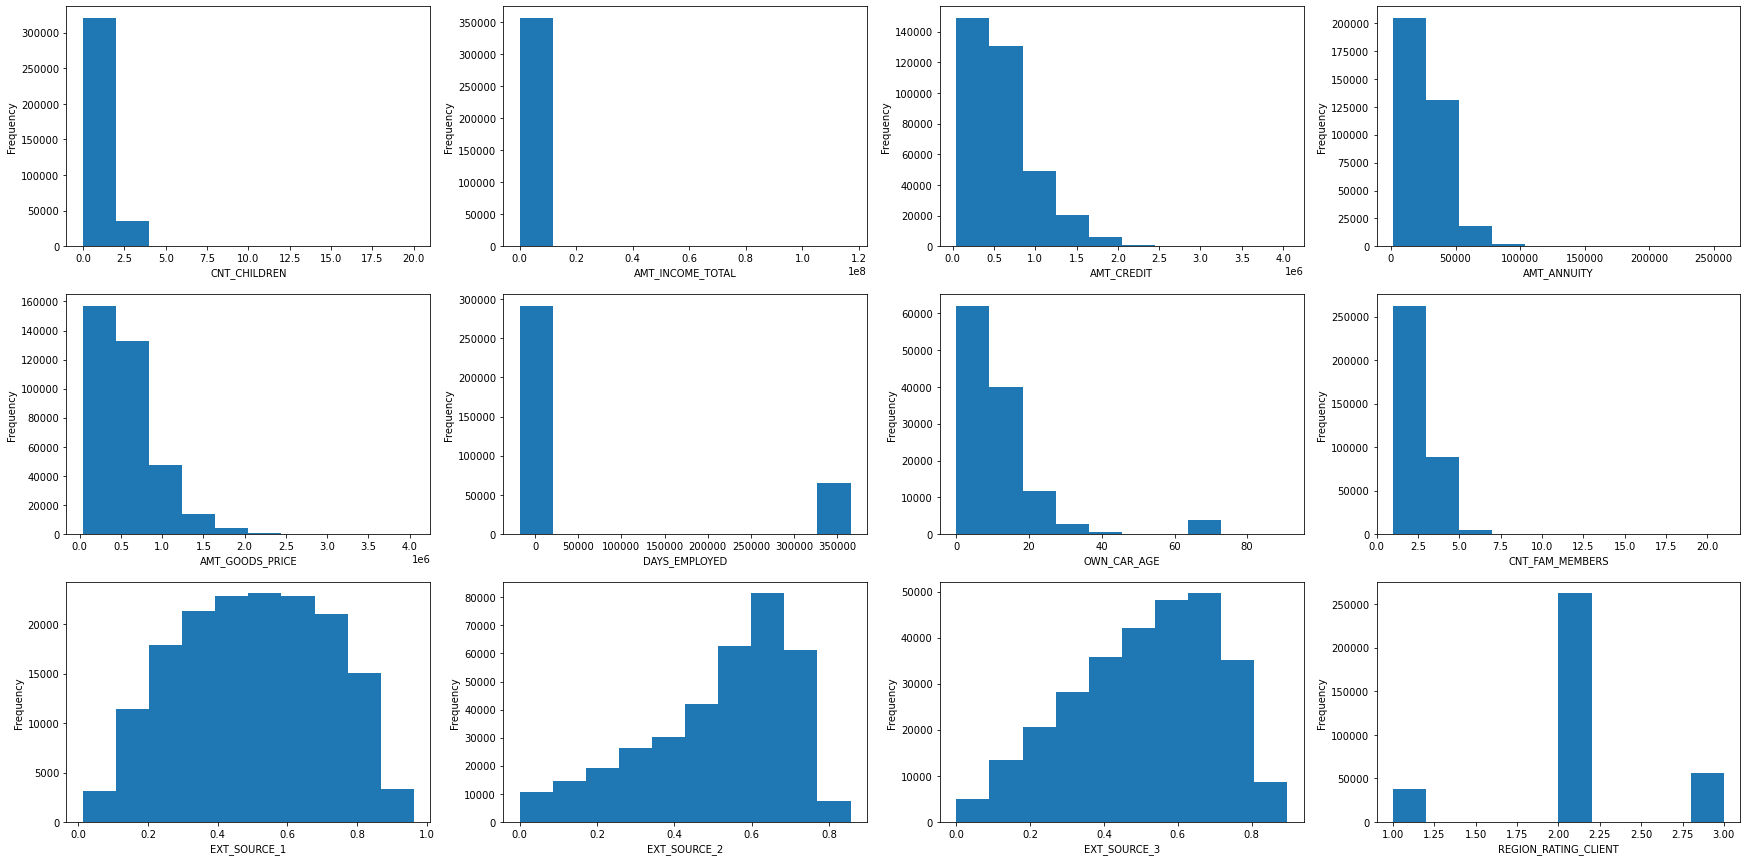

In [282]:
fig = plt.figure(figsize=(30, 15))

num_list = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                  'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS','EXT_SOURCE_1', 'EXT_SOURCE_2',
                   'EXT_SOURCE_3','REGION_RATING_CLIENT']

i=0
for column in selcted_columns:
    sub = fig.add_subplot(3, 4, i+1)
    sub.set_xlabel(column)
    df_initial[column].plot(kind = 'hist')
    i = i + 1

<p class="h3"; style="color:blue">4.2 Bivariate Analysis </p>

In [278]:
# Make a correlation Matrix

df.corr().style.background_gradient(cmap='coolwarm')

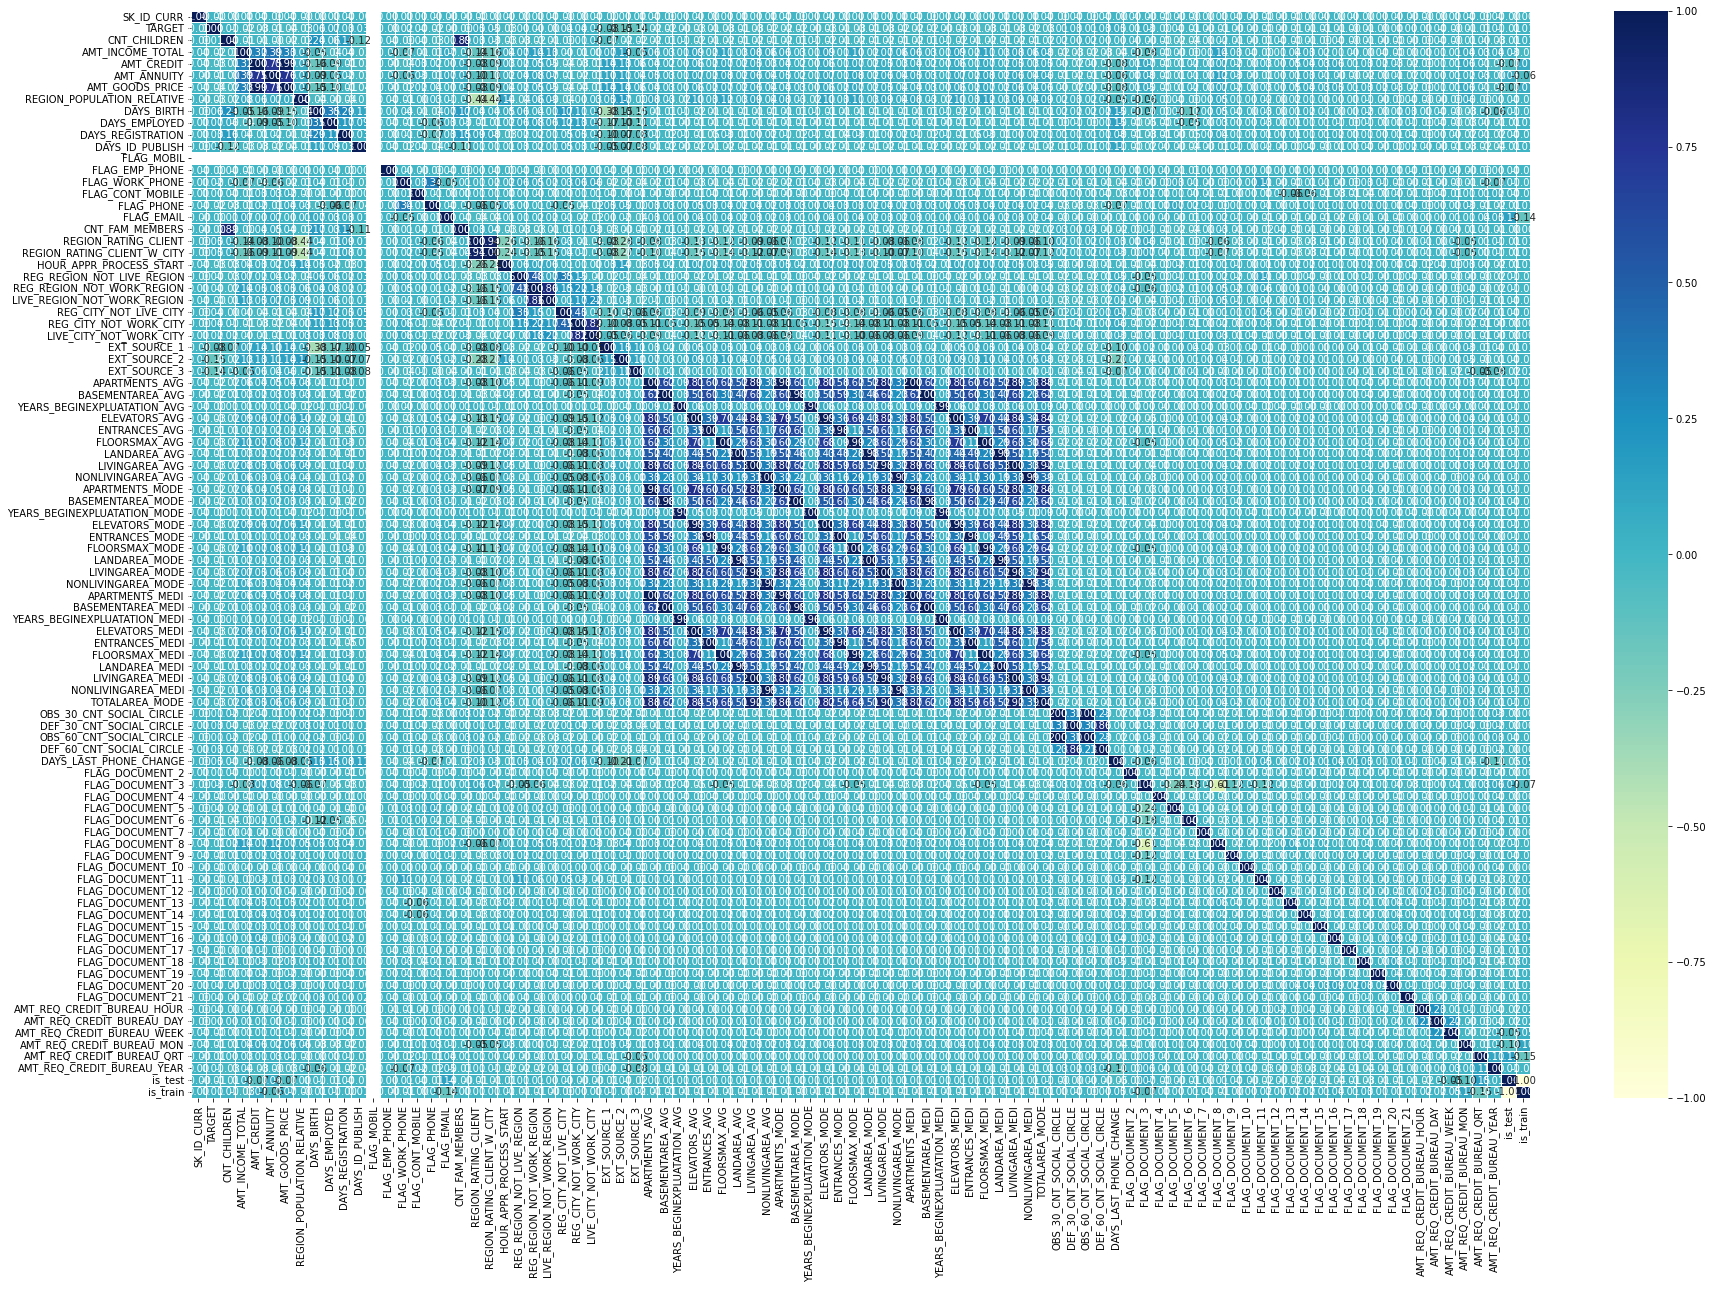

In [281]:
# Let's make our correlation matrix a little prettier

corr_matrix = df_without_outliers.corr()
fig, ax = plt.subplots(figsize=(30, 20))

ax = sns.heatmap(corr_matrix,
                  annot=True,
                  linewidths=0.5,
                  fmt=".2f",
                  cmap="YlGnBu");
 
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0);

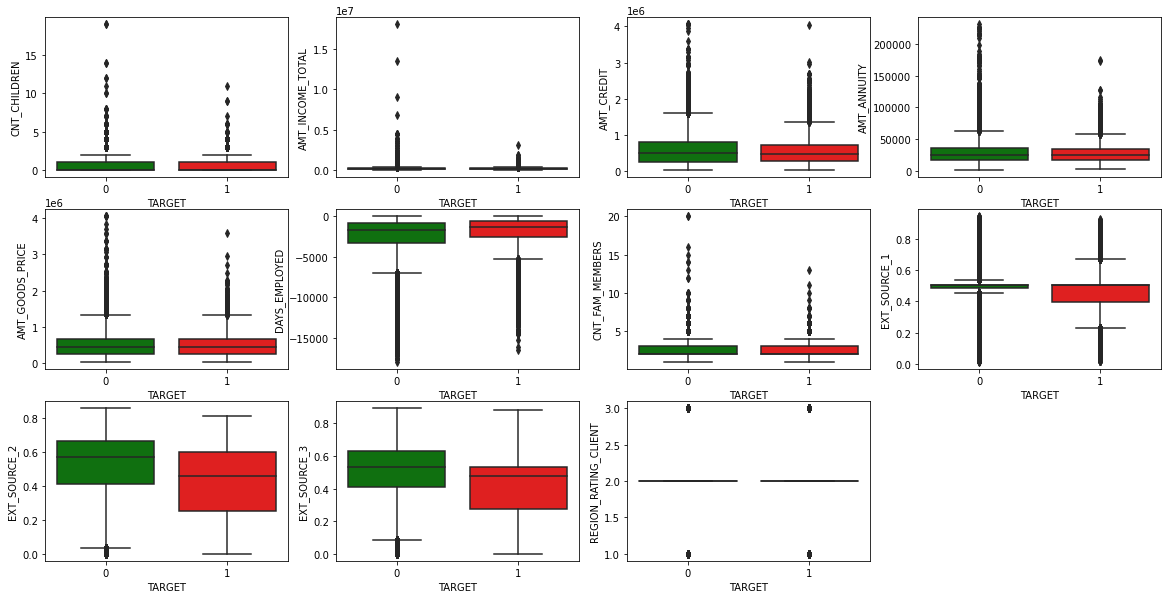

In [285]:
 # box plot 

num_list = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                  'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS','EXT_SOURCE_1', 'EXT_SOURCE_2',
                   'EXT_SOURCE_3','REGION_RATING_CLIENT']    
    
fig = plt.figure(figsize = (20, 10))

for i in range(len(num_list)):
    column = num_list[i]
    sub = fig.add_subplot(3, 4, i+1)
    sns.boxplot(x='TARGET', y=column, data=df_without_outliers, palette=["green", 'red'])

In [288]:
print(cat_columns)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


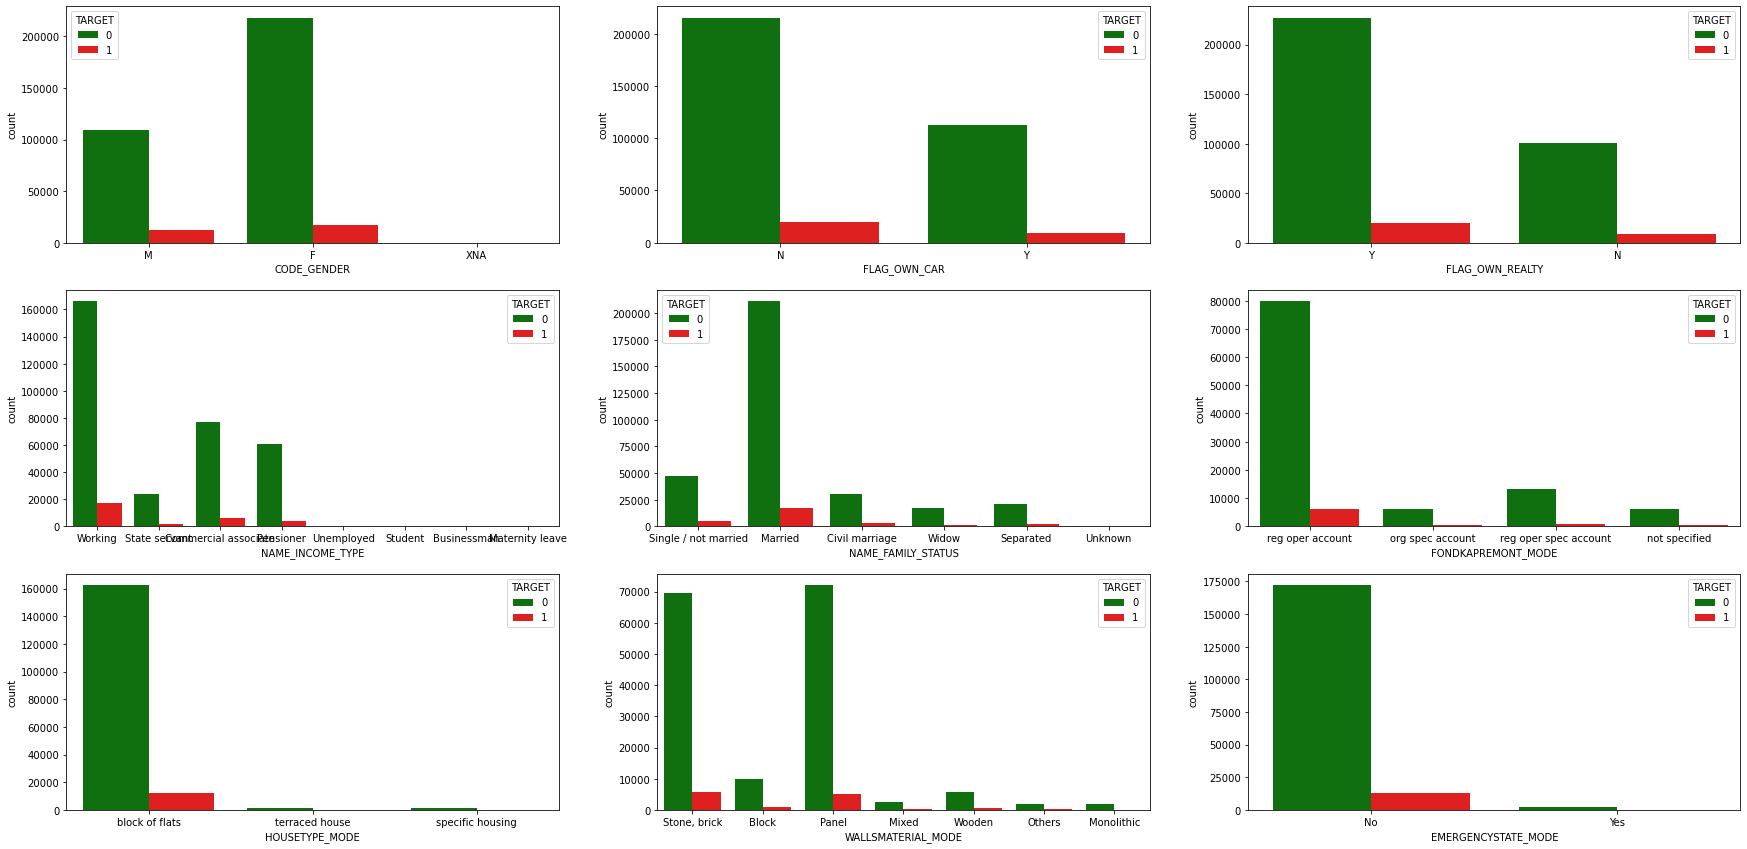

In [295]:
# bar plot 
#df.select_dtypes(include=['object']).columns
cat_list = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",'NAME_INCOME_TYPE', 
            'NAME_FAMILY_STATUS', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
            'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
fig = plt.figure(figsize = (30, 20))

for i in range(len(cat_list)):
    column = cat_list[i]
    sub = fig.add_subplot(4, 3, i+1)
    chart = sns.countplot(data=df_initial, x=column, hue="TARGET", palette=["green", "red"])

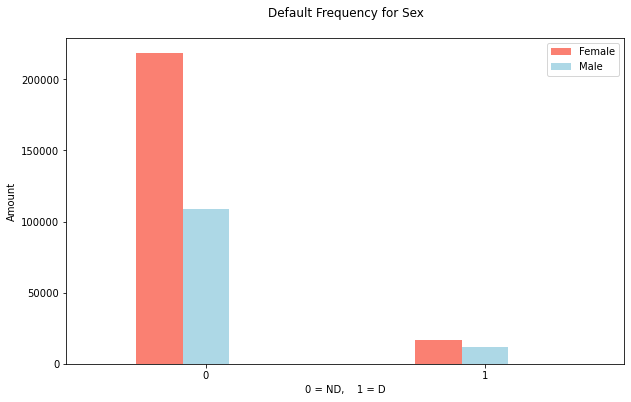

In [297]:
# Create a plot of crosstab 
pd.crosstab(df["TARGET"], df["CODE_GENDER"]).plot(kind="bar",
                                    figsize=(10, 6),
                                    color=["salmon", "lightblue"])

plt.title("Default Frequency for Sex\n")
plt.xlabel("0 = ND,    1 = D")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks(rotation=0);

<p class="h2"; style="color:green; text-align:left; background-color:white"> 5. Feature Engineering</p>


<p class="h3"; style="color:blue">5.1 Creating new features from existing  </p>

In [331]:
df_without_outliers.shape

(280575, 107)

In [334]:
df_initial_cleaned = df_without_outliers.copy()

In [336]:
def new_features_creation(df):
    
    df_features = df.copy()
    
    df_features['DAYS_EMPLOYED_PERC'] = df_features['DAYS_EMPLOYED'] / df_features['DAYS_BIRTH']
    df_features['INCOME_CREDIT_PERC'] = df_features['AMT_INCOME_TOTAL'] / df_features['AMT_CREDIT']
    df_features['INCOME_PER_PERSON'] = df_features['AMT_INCOME_TOTAL'] / df_features['CNT_FAM_MEMBERS']
    df_features['ANNUITY_INCOME_PERC'] = df_features['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df_features['PAYMENT_RATE'] = df_features['AMT_ANNUITY'] / df_features['AMT_CREDIT']
    
    return df_features 

In [338]:
df_initial_features = new_features_creation(df_initial_cleaned)

df_initial_cleaned.shape, df_initial_features.shape

((280575, 107), (280575, 112))

<p class="h3"; style="color:blue">5.2 Encoding cat. features and scaling num. features </p>

In [308]:
from sklearn.preprocessing import MinMaxScaler

def features_encoding(df):
    
    with timer("Encoding categorical features "):
        # Encode des variable catégorielles
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
        df_hot_encode = pd.get_dummies(df, columns= categorical_columns)
    
    with timer("Scaling numeric features "):
        # Standardisation des variables numériques 
        ignore_features = ['is_train', 'is_test', 'TARGET', 'SK_ID_CURR']
        features_to_scaled = [col for col in df_hot_encode.columns if col not in ignore_features]
     
        scaler = MinMaxScaler()
        df_scaled = scaler.fit_transform(df_hot_encode[features_to_scaled])     
        df_scaled = pd.DataFrame(df_scaled, columns=features_to_scaled, index=df['SK_ID_CURR'])
    
    df_encoded = pd.merge(df_hot_encode[ignore_features], df_scaled, on='SK_ID_CURR')
    
    return df_encoded

In [339]:
df_initial_encoded = features_encoding(df_initial_features)

Encoding categorical features  - done in 1s
Scaling numeric features  - done in 2s


In [341]:
df_initial_features.shape, df_initial_encoded.shape

((280575, 112), (280575, 233))

In [342]:
df_initial_encoded.head()

is_train  is_test  TARGET  SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0         1        0       1      100002           0.0             0.010   
1         1        0       0      100003           0.0             0.014   
2         1        0       0      100004           0.0             0.002   
3         1        0       0      100006           0.0             0.006   
4         1        0       0      100007           0.0             0.005   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0       0.090        0.100            0.077                       0.404   
1       0.312        0.148            0.272                       0.072   
2       0.022        0.021            0.024                       0.213   
3       0.067        0.121            0.064                       0.169   
4       0.117        0.087            0.118                       0.618   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0       0.881          0.964              0.841            0.705         0.0   
1       0.472          0.934              0.948            0.960         0.0   
2       0.345          0.987              0.814            0.648         0.0   
3       0.347          0.830              0.571            0.661         0.0   
4       0.295          0.830              0.812            0.520         0.0   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0             1.0              0.0               1.0         1.0         0.0   
1             1.0              0.0               1.0         1.0         0.0   
2             1.0              1.0               1.0         1.0         0.0   
3             1.0              0.0               1.0         0.0         0.0   
4             1.0              0.0               1.0         0.0         0.0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0            0.000                   0.5                         0.75   
1            0.053                   0.0                         0.50   
2            0.000                   0.5                         0.75   
3            0.053                   0.5                         0.75   
4            0.000                   0.5                         0.75   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                    0.435                         0.0   
1                    0.478                         0.0   
2                    0.391                         0.0   
3                    0.739                         0.0   
4                    0.478                         0.0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     1.0                      1.0   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0         0.075         0.308         0.155           0.025             0.037   
1         0.320         0.728         0.597           0.096             0.053   
2         0.529         0.650         0.816           0.088             0.076   
3         0.529         0.761         0.597           0.088             0.076   
4         0.529         0.377         0.597           0.088             0.076   

   YEARS_BEGINEX

<p class="h3"; style="color:blue">5.3 Preprocessing Function </p>

In [344]:
def preprocessing(df) :
    
    with timer("Preparing data for modeling "):
        df = new_features_creation(df)
        df = nan_imputation(df)
        df = removing_outliers(df)
        df = features_encoding(df)
          
    ignore_features = ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']
    relevant_features = [col for col in df.columns if col not in ignore_features]
    
    trainX = df[df['is_train'] == 1][relevant_features + ['TARGET']]
    testX = df[df['is_test'] == 1][relevant_features]
    
    trainy = trainX['TARGET']
    
    return trainX, testX, trainy

In [351]:
trainX_i, testX_i, trainy_i = preprocessing(df_initial)

Filtering cols with a given % of missing_rate  - done in 2s
Imputing numeric nan value with median  - done in 4s
Imputing categorical nan value with Unknown  - done in 0s

Taille du jeu de donnée avant imputation:  (356255, 129)
Taille du jeu de donnée après imputation:  (352303, 112)
	Soit 17 variables et 3952 observations supprimées
Proportion de données supprimés : 0.0086%
Encoding categorical features  - done in 1s
Scaling numeric features  - done in 2s
Preparing data for modeling  - done in 15s


In [346]:
trainX_i.shape, testX_i.shape, trainy_i.shape

((243056, 230), (37519, 229), (243056,))

In [347]:
trainX_i.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0             0.010       0.090        0.100            0.077   
1           0.0             0.014       0.312        0.148            0.272   
2           0.0             0.002       0.022        0.021            0.024   
3           0.0             0.006       0.067        0.121            0.064   
4           0.0             0.005       0.117        0.087            0.118   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.404       0.881          0.964              0.841   
1                       0.072       0.472          0.934              0.948   
2                       0.213       0.345          0.987              0.814   
3                       0.169       0.347          0.830              0.571   
4                       0.618       0.295          0.830              0.812   

   DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            0.705         0.0             1.0              0.0   
1            0.960         0.0             1.0              0.0   
2            0.648         0.0             1.0              1.0   
3            0.661         0.0             1.0              0.0   
4            0.520         0.0             1.0              0.0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0               1.0         1.0         0.0            0.000   
1               1.0         1.0         0.0            0.053   
2               1.0         1.0         0.0            0.000   
3               1.0         0.0         0.0            0.053   
4               1.0         0.0         0.0            0.000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                   0.5                         0.75                    0.435   
1                   0.0                         0.50                    0.478   
2                   0.5                         0.75                    0.391   
3                   0.5                         0.75                    0.739   
4                   0.5                         0.75                    0.478   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                     0.0                      0.0         0.075   
1                     0.0                      0.0         0.320   
2                     0.0                      0.0         0.529   
3                     0.0                      0.0         0.529   
4                     1.0                      1.0         0.529   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0         0.308         0.155           0.025             0.037   
1         0.728         0.597           0.096             0.053   
2         0.650         0.816           0.088             0.076   
3         0.761         0.597           0.088             0.076   
4         0.377         0.597           0.088             0.076   

   YEARS_BEGINEXPLUATATION_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0                        0.972           0.00          0.069          0.083   
1                        0.985           0.08          0.035          0.292   
2            

<p class="h3"; style="color:blue">5.4 Grouping all datasets for more features </p>

In [300]:
def grouping_datasets():
    
    """App train and app test"""
    with timer("Process application data "):
        app_test['is_test'] = 1
        app_test['is_train'] = 0
        app_train['is_test'] = 0
        app_train['is_train'] = 1
        # target variable
        train_y = app_train['TARGET']
        train_X = app_train.drop(['TARGET'], axis = 1)
        test_X = app_test 
        test_id = app_test['SK_ID_CURR']
 
    """Previous applications"""
    with timer("Process previous application data "):
        ## count the number of previous applications for a given ID
        prev_apps_count = prev_app[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
        prev_app['SK_ID_PREV'] = prev_app['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])
        ## Average values for all other features in previous applications
        prev_apps_avg = prev_app.groupby('SK_ID_CURR').mean()
        prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
   
    
    """Bureau Data"""
    with timer("Process bureau data "):
    # Average Values for all bureau features 
        bureau_avg = bureau.groupby('SK_ID_CURR').mean()
        bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()\
                                                                                                ['SK_ID_BUREAU']
        bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
    
    """Previous Installements"""
    with timer("Process installements data "):
        ## count the number of previous installments
        count_inst = inst_pay[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
        inst_pay['SK_ID_PREV'] = inst_pay['SK_ID_CURR'].map(count_inst['SK_ID_PREV'])
        ## Average values for all other variables in installments payments
        avg_inst = inst_pay.groupby('SK_ID_CURR').mean()
        avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
    
    """POS_CASH_balance"""
    with timer("Process POS_CASH_balance data "):
        ### count the number of pos cash for a given ID
        pcb_count = pos_cash_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
        pos_cash_bal['SK_ID_PREV'] = pos_cash_bal['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])
        ## Average Values for all other variables in pos cash
        pcb_avg = pos_cash_bal.groupby('SK_ID_CURR').mean()
       
    """credit_card_balance"""
    with timer("Process credit_card_balance data "):
        ### count the number of previous applications for a given ID
        nb_prevs = cred_card_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
        cred_card_bal['SK_ID_PREV'] = cred_card_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
        ### average of all other columns 
        avg_cc_bal = cred_card_bal.groupby('SK_ID_CURR').mean()
        avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
       
    with timer("Merging data for preprocessing "):
         # merge train and test datasets for preprocessing
        data = pd.concat([train_X, test_X], axis=0)
        
        # Merging datasets togethher
        data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')
        data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
        data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
        data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')
        data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

    #### prepare final Train X and Test X dataframes 
    ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
    relevant_features = [col for col in data.columns if col not in ignore_features]
    trainX = data[data['is_train'] == 1][relevant_features]
    testX = data[data['is_test'] == 1][relevant_features]
    
    trainy = app_train['TARGET']
    
    df_final = data.copy()
    df_final.insert(1, 'TARGET', app_train['TARGET']) 
    
    return df_final, trainX, trainy, testX

In [304]:
df_final, trainX_f, trainy_f, testX_f = grouping_datasets()

df_final.shape, trainX_f.shape, testX_f.shape, testX_f.shape

Process application data  - done in 1s
Process previous application data  - done in 3s
Process bureau data  - done in 1s
Process installements data  - done in 8s
Process POS_CASH_balance data  - done in 6s
Process credit_card_balance data  - done in 4s
Merging data for preprocessing  - done in 10s


((356255, 192), (307511, 188), (48744, 188), (48744, 188))

In [350]:
#print_proportion_nan(trainX_i)

In [352]:
trainX_f, testX_f, trainy_f = preprocessing(df_final)

Filtering cols with a given % of missing_rate  - done in 2s
Imputing numeric nan value with median  - done in 12s
Imputing categorical nan value with Unknown  - done in 0s

Taille du jeu de donnée avant imputation:  (356255, 197)
Taille du jeu de donnée après imputation:  (352303, 156)
	Soit 41 variables et 3952 observations supprimées
Proportion de données supprimés : 0.0056%
Encoding categorical features  - done in 1s
Scaling numeric features  - done in 2s
Preparing data for modeling  - done in 25s


<p class="h3"; style="color:blue">5.5 Saving files for modeling </p>

In [353]:
#df_initial.to_csv('data_initial.csv', index=False)
#df_final.to_csv('data_final.csv', index=False)

In [354]:
df_initial.to_parquet('data/data_initial.parquet')
df_final.to_parquet('data/data_final.parquet')

In [362]:
df_initial.shape, df_final.shape

((356255, 124), (356255, 192))

In [359]:
df_initial.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0   4.066e+05      24700.5   
1               N             0          270000.0   1.294e+06      35698.5   
2               Y             0           67500.0   1.350e+05       6750.0   
3               Y             0          135000.0   3.127e+05      29686.5   
4               Y             0          121500.0   5.130e+05      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0        3.510e+05   Unaccompanied          Working   
1        1.130e+06          Family    State servant   
2        1.350e+05   Unaccompanied          Working   
3        2.970e+05   Unaccompanied          Working   
4        5.130e+05   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019       -9461           -637            -3648.0   
1                       0.004      -16765          -1188            -1186.0   
2                       0.010      -19046           -225            -4260.0   
3                       0.008      -19005          -3039            -9833.0   
4                       0.029      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [360]:
df_final.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002     1.0         Cash loans           M            N   
1      100003     0.0         Cash loans           F            N   
2      100004     0.0    Revolving loans           M            Y   
3      100006     0.0         Cash loans           F            N   
4      100007     0.0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0   4.066e+05      24700.5   
1               N             0          270000.0   1.294e+06      35698.5   
2               Y             0           67500.0   1.350e+05       6750.0   
3               Y             0          135000.0   3.127e+05      29686.5   
4               Y             0          121500.0   5.130e+05      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0        3.510e+05   Unaccompanied          Working   
1        1.130e+06          Family    State servant   
2        1.350e+05   Unaccompanied          Working   
3        2.970e+05   Unaccompanied          Working   
4        5.130e+05   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019       -9461           -637            -3648.0   
1                       0.004      -16765          -1188            -1186.0   
2                       0.010      -19046           -225            -4260.0   
3                       0.008      -19005          -3039            -9833.0   
4                       0.029      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        